# COVID-19 en Chile

In [25]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np


%matplotlib inline

In [26]:
# Datos de población
county_population_raw = pd.read_csv(
    "https://www.ine.cl/docs/default-source/proyecciones-de-poblacion/cuadros-estadisticos/base-2017/ine_estimaciones-y-proyecciones-de-poblaci%C3%B3n-1992-2050_base-2017_base-de-datos.csv",
    encoding='ISO-8859-1', sep=";", thousands='.')

#Extraigo datos del 2021 para ambos sexos, limpio nombres de columnas
Pob2021 = county_population_raw.iloc[1:102,[0,30]].rename({"POBLACIÓN TOTAL (AMBOS SEXOS)":"Edad", "Unnamed: 30": "Población"}, axis =1)

#El último valor, de mayores de 100 años será representado por 100, para mantener valores en formato int
Pob2021.iloc[100,0] = 100
Pob2021 = Pob2021.astype(int)

#Uso Edad como índice
Pob2021.set_index('Edad', inplace = True)

#Extraigo los totales de poblacion para luego utilizarlo para calcular % de Vacunad@s
Pob_total = Pob2021['Población'].sum()

In [27]:
Pob_grupos = pd.Series(name = 'Población')
Pob_grupos.loc['<=39'] = Pob2021[Pob2021.index <= 39].values.sum()
Pob_grupos.loc['40-49'] = Pob2021[(Pob2021.index >= 40) & (Pob2021.index <= 49)].values.sum()
Pob_grupos.loc['50-59'] = Pob2021[(Pob2021.index >= 50) & (Pob2021.index <= 59)].values.sum()
Pob_grupos.loc['60-69'] = Pob2021[(Pob2021.index >= 60) & (Pob2021.index <= 69)].values.sum()
Pob_grupos.loc['>=70'] = Pob2021[Pob2021.index >= 70].values.sum()

In [28]:
Pob_grupos

<=39     11155053
40-49     2658453
50-59     2392614
60-69     1857879
>=70      1614364
Name: Población, dtype: int64

# Casos

In [29]:
casos = pd.read_csv('https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/input/ReporteDiario/CasosConfirmadosTotales.csv')
casos = casos.drop_duplicates()
casos.set_index('Fecha', inplace = True)
casos.index = pd.to_datetime(casos.index, format = '%d-%m-%Y')
dia_datos = pd.to_datetime(casos.index[-1]).strftime('%d/%m')

Text(0.5, 1.0, 'Casos diarios al 30/07')

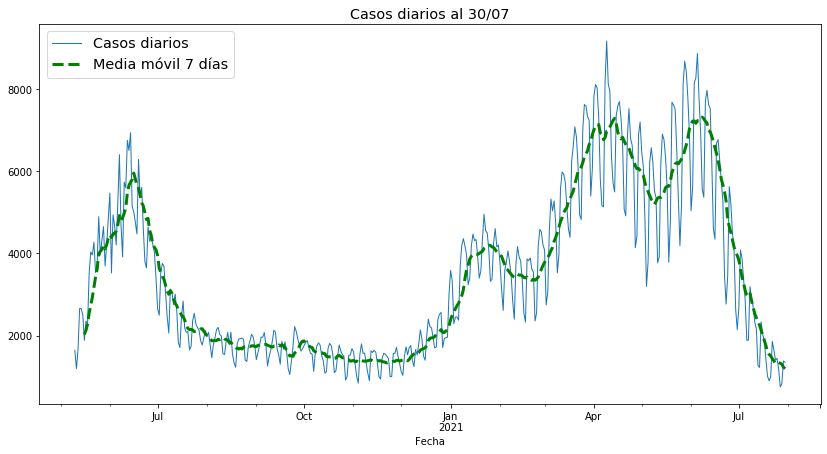

In [30]:
fig, ax = plt.subplots(figsize=(14,7))
casos.iloc[:,4].plot(ax=ax, label = 'Casos diarios', lw = 1)
casos.iloc[:,4].rolling(7).mean().plot(ax=ax, lw=3, label = 'Media móvil 7 días', linestyle = 'dashed', color = 'green')
ax.legend(fontsize = 'x-large')
ax.set_title(f'Casos diarios al {dia_datos}', fontsize='x-large')

## Casos por grupo etario

In [31]:
caos_edad_etapa = pd.read_csv('https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto16/CasosGeneroEtarioEtapaClinica.csv')

In [32]:
casos_g_edad = pd.read_csv('https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto16/CasosGeneroEtario.csv')
casos_edad = casos_g_edad.groupby('Grupo de edad').sum().T #junto datos de los dos géneros
casos_edad.index = pd.to_datetime(casos_edad.index) #indice como fechas

primera_fecha = casos_edad.index[0]
ultima_fecha = casos_edad.index[-1]

#los datos son cada 3/4 días, creo nuevo índice con todos los días para interpolar
date_index2 = pd.date_range(start = primera_fecha, end = ultima_fecha, freq='D') 
casos_edad = casos_edad.reindex(date_index2)

casos_edad_int = casos_edad.interpolate() #interpolación para rellenar los días sin datos

#casos diarios como diferencia entre dos días
casos_diarios_edad = casos_edad_int.diff(1).T

In [33]:
#creo grupos etarios
casos_diarios_edad.loc['00 - 04 años':'35 - 39 años','grupo']='<=39'
casos_diarios_edad.loc['40 - 44 años':'45 - 49 años','grupo']='40-49'
casos_diarios_edad.loc['50 - 54 años':'55 - 59 años','grupo']='50-59'
casos_diarios_edad.loc['60 - 64 años':'65 - 69 años','grupo']='60-69'
casos_diarios_edad.loc['70 - 74 años':,'grupo']='>=70'

casos_grupos = casos_diarios_edad.groupby('grupo', sort=False).sum().T
casos_grupos_media = casos_grupos.rolling(7).mean() #media móvil

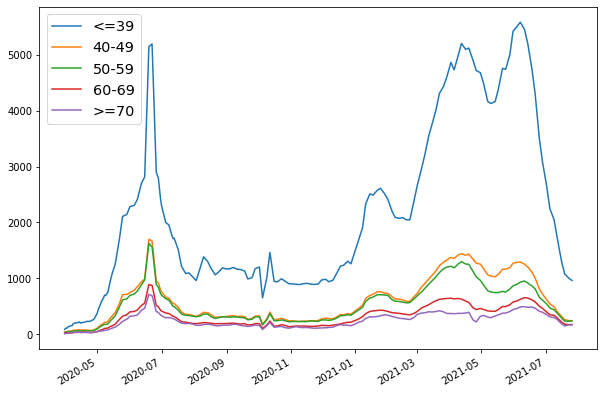

In [34]:
fig, ax = plt.subplots(figsize=(10,7))
casos_grupos_media.plot(ax = ax)
ax.legend(fontsize = 'x-large')

In [35]:
incidencia = casos_grupos_media.div(Pob_grupos, axis = 1)*100000

In [36]:
incidencia_semanal = casos_grupos.rolling(7).sum().div(Pob_grupos, axis = 1)*100000

Text(0.5, 1.0, 'Incidencia por grupo etario (Casos por 100.000 habitantes)')

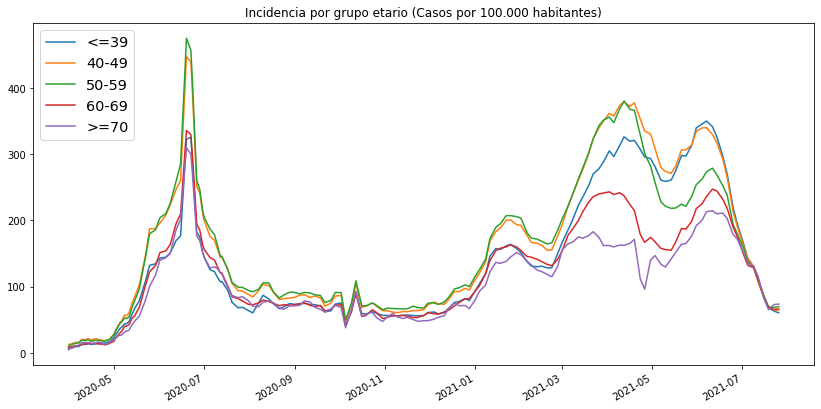

In [37]:
fig, ax = plt.subplots(figsize=(14,7))
incidencia_semanal.plot(ax = ax)
ax.legend(fontsize = 'x-large')
ax.set_title('Incidencia por grupo etario (Casos por 100.000 habitantes)')

In [38]:
#distribución % de casos en los grupos etarios
casos_grupos_media_p = casos_grupos_media.div(casos_grupos_media.sum(axis=1).values, axis=0)

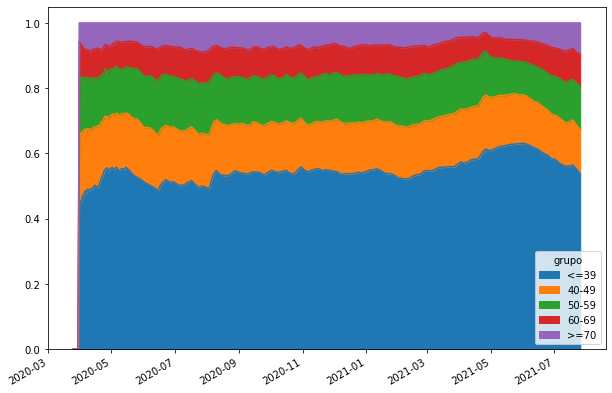

In [39]:
casos_grupos_media_p.plot(kind='area', stacked=True, figsize=(10,7))

# Hospitalizados UCI

In [40]:
hosp_edad = pd.read_csv('https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/input/ReporteDiario/HospitalizadosUCIEtario.csv')
hosp_edad.set_index('Grupo de edad', inplace = True)
hosp_edad.columns = pd.to_datetime(hosp_edad.columns)
hosp_edad = hosp_edad.T
hosp_edad_p = hosp_edad.div(hosp_edad.sum(axis=1).values, axis=0) # hospitalizados por grupo en porcentaje

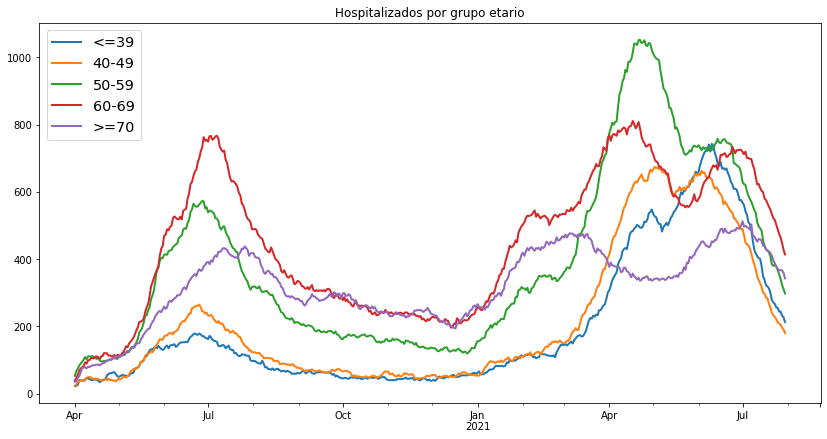

In [41]:
fig, ax = plt.subplots(figsize=(14,7))
hosp_edad.plot(ax = ax, lw = 2)
ax.set_title('Hospitalizados por grupo etario')
ax.legend(loc = 2, fontsize = 'x-large')


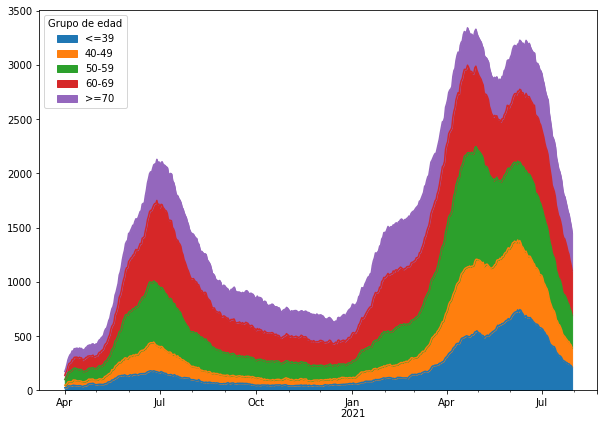

In [42]:
hosp_edad.plot(figsize = (10,7), kind = 'area', stacked = True)

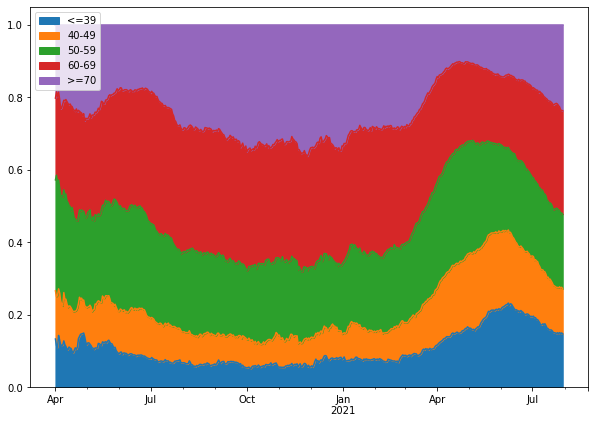

In [43]:
#hospitalizados hoy vs inicio vacunación
fig, ax = plt.subplots()
hosp_edad_p.plot(kind='area', stacked=True, figsize=(10,7), ax=ax)
ax.legend(loc=2)

## Fallecidos etarios

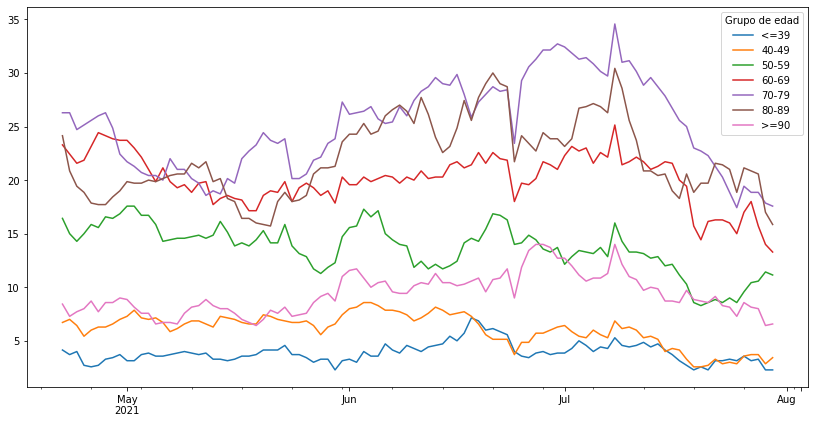

In [44]:
fallecidos_edad = pd.read_csv('https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/input/ReporteDiario/FallecidosEtario.csv')
fallecidos_edad = fallecidos_edad.set_index('Grupo de edad').T
fallecidos_edad.index = pd.to_datetime(fallecidos_edad.index)
fallecidos_edad.diff(1).rolling(7).mean().iloc[-100:,:].plot(figsize = (14,7))

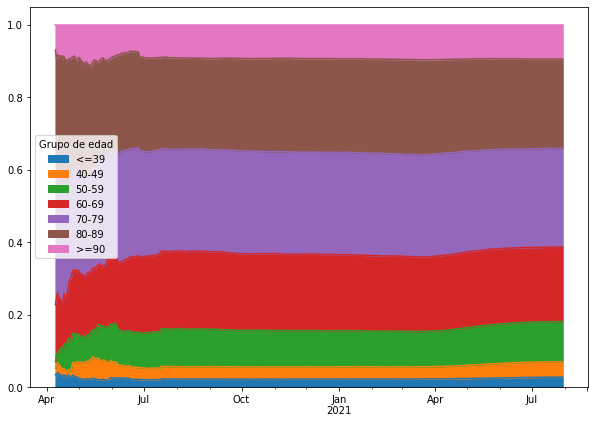

In [45]:
fallecidos_edad_p = fallecidos_edad.div(fallecidos_edad.sum(axis = 1).values, axis = 0)
fallecidos_edad_p.plot(figsize = (10,7), kind = 'area', stacked = True)

In [46]:
fallecidos_7dias = fallecidos_edad.diff(1).rolling(7).mean().sum(axis = 1) #total fallecidos, media móvil
fallecidos_7dias_desp = fallecidos_7dias.copy()

#fallecidos hace 7 días, para comparar con casos
fallecidos_7dias_desp.index = fallecidos_7dias.index - pd.Timedelta(10, 'D') 

# Fallecidos vs Casos

Text(-100, -40, 'Fuentes: MinCiencia\nAutor: @_luqui_')

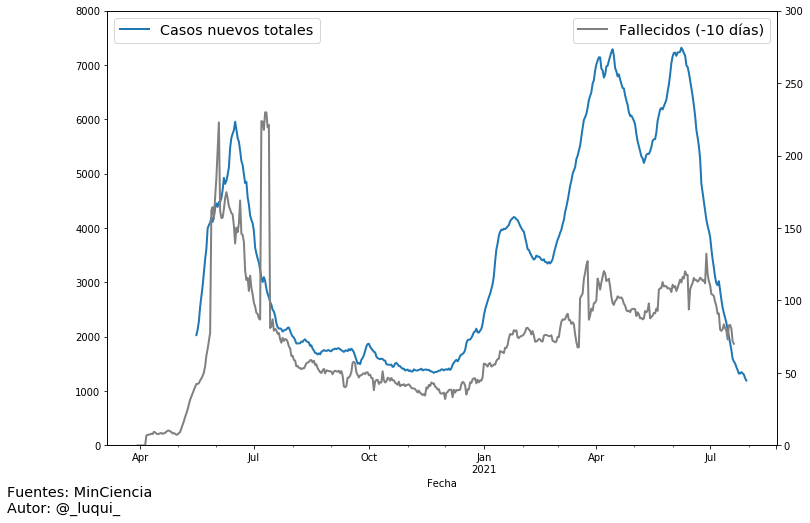

In [47]:
fig, ax = plt.subplots(figsize = (12,8))
ax2 = ax.twinx()
casos.iloc[:,4].rolling(7).mean().plot(ax=ax, lw=2)
fallecidos_7dias_desp.plot(ax=ax2, color = 'grey', lw=2, label = 'Fallecidos (-10 días)')
ax.set_ylim(0,8000)
ax2.set_ylim(0,300)
ax.legend(fontsize = 'x-large', loc = 2)
ax2.legend(fontsize = 'x-large', loc = 1)
plt.annotate('Fuentes: MinCiencia\nAutor: @_luqui_', (0,0), (-100,-40), fontsize='x-large', xycoords='axes fraction', textcoords='offset points', va='top')

## Letalidad

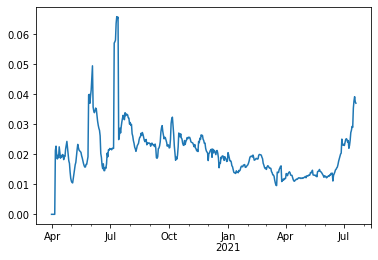

In [48]:
fallecidos_7dias_desp.div(casos_grupos_media.sum(axis = 1)).plot()